This is Fredrik Knapskogs pre christmas fun while procastinating the take at home exam in Pedagogy. An efficient algorithm for determining the N first primes
is made and implemented with Numba for machine code speed and parallelisation and executed for the billion first primes. The array of values is stored and
occupies 7.5 GB. The rate of prime values, the cummulative largest gap and the gap distributions are studied and modelled. Lastly the Mersenne primes up to $2^{61}-1$ are found.

In [1]:
#importing libraries, numba must be installed in advance
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook
from numba import jit, prange
from time import *
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #for use of the full screen

Part 1: Finding the N first primes

In [5]:
#testing only numbers not divisible by 2 and 3
for n_i in range(2, 10):
    print(6*(n_i//2) + 2*(n_i%2) - 1)

5
7
11
13
17
19
23
25


In [2]:
#function to be run in parallel, does not test for divisibility of 2 and 3
@jit(nopython=True)
def is_prime(primes, n):
    root = np.sqrt(n)
    i = 2
    while primes[i] <= root: #numbers beside primes can't have their first factor greater than their root
        if n%primes[i] == 0:
            return False
        else:
            i += 1
    return True

#numba core 0, tells the other cores which numbers to test for primeness in is_prime
@jit(nopython=True, parallel = True)
def numba_kernel(primes, N, segment, seg, start):
    primes[0] = 2
    primes[1] = 3
    primes[2] = 5
    i = 3
    n_i = 3
    
    #the start is serial as all the numbers below the root of the prime must be known
    if N < start: 
        while i < N:
            n = 6*(n_i//2) + 2*(n_i%2) - 1
            if is_prime(primes, n):
                primes[i] = n
                i += 1
            n_i += 1
            
    else:
        while i < start:
            n = 6*(n_i//2) + 2*(n_i%2) - 1
            if is_prime(primes, n):
                primes[i] = n
                i += 1
            n_i += 1
        
        #when sufficient numbers are found the process can be parallelised
        while i < N:
            segment *= np.inf #to get the right order of the primes, the tested numbers are stored in an temporary array before added to the output array
            for j in prange(seg):
                if is_prime(primes, 6*((n_i+j)//2) + 2*((n_i+j)%2) - 1):
                    segment[j] = 6*((n_i+j)//2) + 2*((n_i+j)%2) - 1
                    
            #here the primes are added to the output array in correct order (independent of parallellisation order)
            if i + seg < N:
                for j in range(seg):
                    if segment[j] < np.inf:
                        primes[i] = segment[j]
                        i += 1
                        
            else:
                for j in range(seg):
                    if i < N:
                        if segment[j] < np.inf:
                            primes[i] = segment[j]
                            i += 1
                    else:
                        break
                        
            n_i += seg
            
    return primes

#main
def find_N_first_primes(N):
    seg = 10000
    start = 50000
    return numba_kernel(np.zeros(N, np.int64), N, np.ones(seg), seg, start)

In [5]:
#execute computation of 1 billion primes, took 5 hours
N = 1000000000
start = time()
primes = find_N_first_primes(N)
end = time()
print(end - start)

17840.217267990112


In [2]:
#save and load the array, don't want to do that computation more than once. File is 7.5 GB though
# np.save("primtall", primes)
primes = np.load("primtall.npy")

In [5]:
#what the last 100 found primes look like
primes[-100:]

array([22801761391, 22801761401, 22801761407, 22801761439, 22801761449,
       22801761457, 22801761469, 22801761491, 22801761497, 22801761511,
       22801761527, 22801761529, 22801761571, 22801761617, 22801761629,
       22801761637, 22801761659, 22801761677, 22801761721, 22801761757,
       22801761761, 22801761769, 22801761817, 22801761823, 22801761847,
       22801761877, 22801761883, 22801761893, 22801761901, 22801761907,
       22801761929, 22801761943, 22801761947, 22801761973, 22801762001,
       22801762013, 22801762019, 22801762033, 22801762073, 22801762127,
       22801762129, 22801762157, 22801762163, 22801762171, 22801762199,
       22801762201, 22801762213, 22801762253, 22801762271, 22801762283,
       22801762301, 22801762303, 22801762309, 22801762327, 22801762331,
       22801762367, 22801762409, 22801762441, 22801762453, 22801762463,
       22801762469, 22801762513, 22801762519, 22801762547, 22801762553,
       22801762559, 22801762579, 22801762603, 22801762619, 22801

In [17]:
#if primes are not needed, it should be cleared from memory
# primes = None
# gaps = None

Part 2: Plotting N first primes as function of their order

In [27]:
#model the behaviour of primes as a linear function
a = (primes[-1] - primes[-1000]) / (np.arange(1, N+1)[-1] - np.arange(1, N+1)[-1000])
b = primes[-1000] - a * np.arange(1, N+1)[-1000]

In [28]:
a, b

(23.693693693693692, -891930204.6936913)

<IPython.core.display.Javascript object>


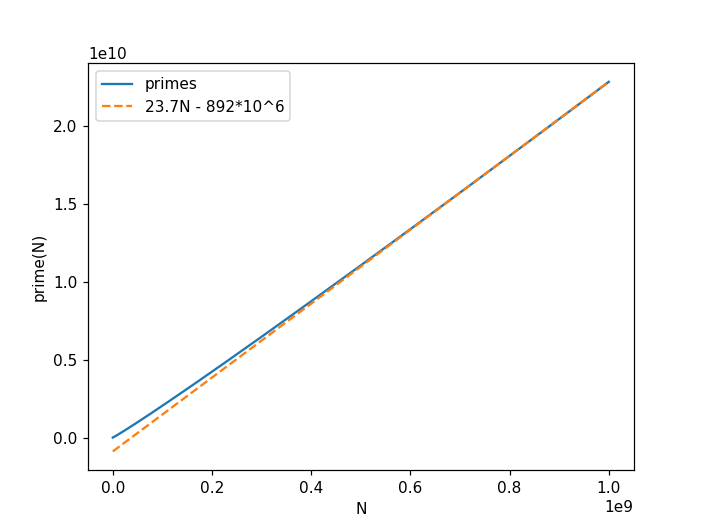

Text(0, 0.5, 'prime(N)')

In [32]:
#plot the results and the model
N = 1000000000
plt.plot(np.arange(1, N+1)[::100000], primes[::100000], label = "primes")
plt.plot(np.arange(1, N+1, 100000), np.arange(1, N+1, 100000)*a + b, "--", label = "23.7N - 892*10^6")
plt.legend()
plt.xlabel("N")
plt.ylabel("prime(N)")

Part 3: The average gap density

In [30]:
#Computing and modelling the average prime gap as a function of N-1 prime gaps
xn = np.logspace(1, 9, 100)
xn = xn.astype(np.int64)-1
avg_gap = np.zeros(len(xn)-1)
for i in range(1, len(xn)-1):
    avg_gap[i] = np.average(primes[xn[i]:xn[i+1]] - primes[xn[i]-1:xn[i+1]-1])

In [51]:
a = (avg_gap[-1] - avg_gap[-10])/np.log(xn[-1]/xn[-10])
b = avg_gap[-1] - a*np.log(xn[-1])
X = np.logspace(1, 9, 1000)
avg_gap[-1], a, b

(23.755329668030672, 1.048318115950915, 2.03075467054137)

<IPython.core.display.Javascript object>


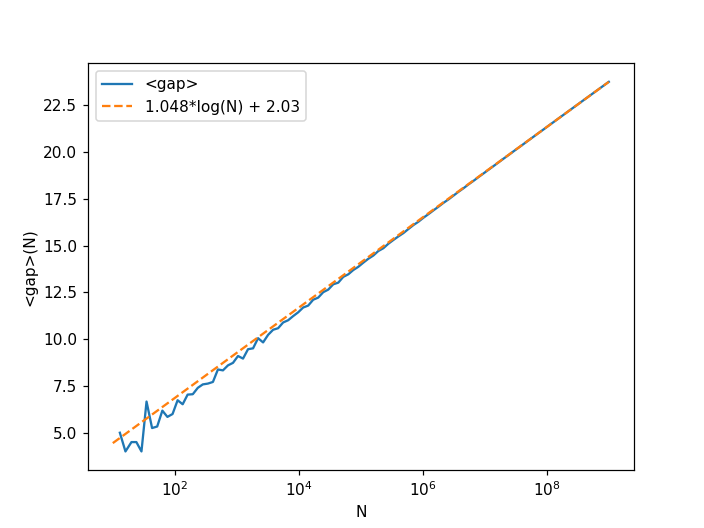

Text(0, 0.5, '<gap>(N)')

In [52]:
#The average prime gap as a function of number of primes. The average prime gap distance approaches 23.7 when N reaches 1 billion which corresponds well with the slope in the model above
N = 1000000000
plt.semilogx(xn[2:], avg_gap[1:], label = "<gap>")
plt.semilogx(X, a*np.log(X)+b, "--", label = "1.048*log(N) + 2.03")
plt.legend()
plt.xlabel("N")
plt.ylabel("<gap>(N)")

Part 4: The largest gap yet between two primes as a function of number of primes before the gap

In [8]:
#find the larges prime gap yet
@jit(nopython=True)
def largest_gap_cummulative(gap, out, N):
    largest = gap[0]
    out[0] = largest
    for i in range(1, N-1):
        if gap[i] > largest:
            largest = gap[i]
        out[i] = largest
    return out

In [9]:
#execute computation of largest gaps so far
N = 1000000000
gaps = largest_gap_cummulative(primes[1:] - primes[:-1], np.zeros(N-1, dtype = np.int32), N)

In [15]:
#model the behaviour of the largest prime gaps yet as a logarithmic function
a = (gaps[-1] - gaps[100000]) / np.log(1e9/1e5)
b = gaps[-1] - a*np.log(1e9)
x = np.logspace(4, 9, 10000)
a, b

(30.400613733227626, -235.9999999999999)

<IPython.core.display.Javascript object>


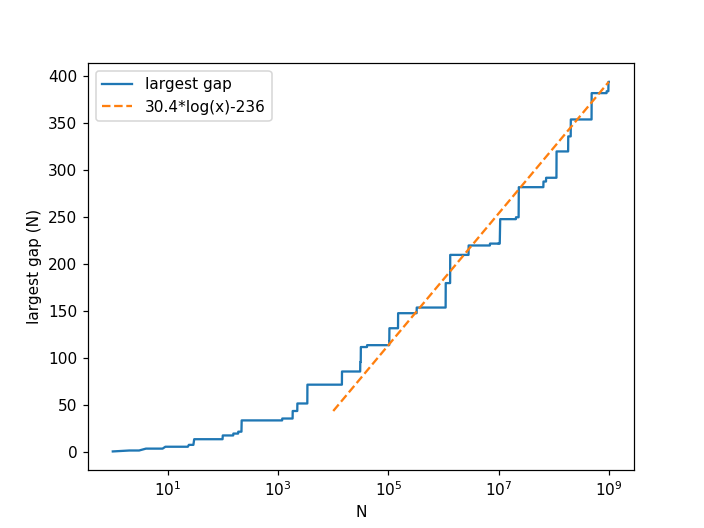

Text(0, 0.5, 'largest gap (N)')

In [10]:
#plot the results and the model with a logarithmic scale on the x axis
N = 1000000000 - 1
plt.semilogx(np.arange(1, N+1)[10000000::100000], gaps[10000000::100000], label = "largest gap", color = "tab:blue")
plt.semilogx(np.arange(1, 10000001), gaps[:10000000], color = "tab:blue")
# plt.plot(np.arange(1, N+1, 100000), np.arange(1, N+1, 100000)*a + b, "--", label = "23.529N - 727*10^6")
plt.semilogx(x, a*np.log(x)+b, color = "tab:orange", label = "30.4*log(x)-236", linestyle = "--")
plt.legend()
plt.xlabel("N")
plt.ylabel("largest gap (N)")

In [17]:
#find the largest gap within all the billion first primes, this will be used as upper limit when finding the gap distribution
gaps[-1]

394

Part 5: The distribution of prime gaps

In [3]:
#filling the gaps into a distribution
@jit(nopython=True, parallel = True)
def gaps_distribution(gaps, distribution, N, largest):
    for i in range(1, N-1):
        distribution[gaps[i]-2] += 1
    return distribution/(N-2)

In [4]:
#executing the computation of the distribution of gaps
N = 1000000000 - 1
distribution = gaps_distribution(primes[1:] - primes[:-1], np.zeros(394, dtype = np.int64), N, 394)

In [25]:
#testing if it is properly normalized
np.sum(distribution)

0.9999999999999999

In [53]:
#modelling the behaviour of the distribution of gaps as an exponential function
a = np.log(distribution[4:150:6][3]/distribution[4:150:6][0])/(np.arange(2, 396)[4:150:6][3] - np.arange(2, 396)[4:150:6][0])

b = np.log(distribution[2:150:6][-1]/distribution[2:150:6][1])/(np.arange(2, 396)[2:150:6][-1] - np.arange(2, 396)[2:150:6][1])

a, distribution[4:150:6][0], np.arange(2, 396)[4:150:6][0]

(-0.044345533012758565, 0.10500285331500855, 6)

<IPython.core.display.Javascript object>


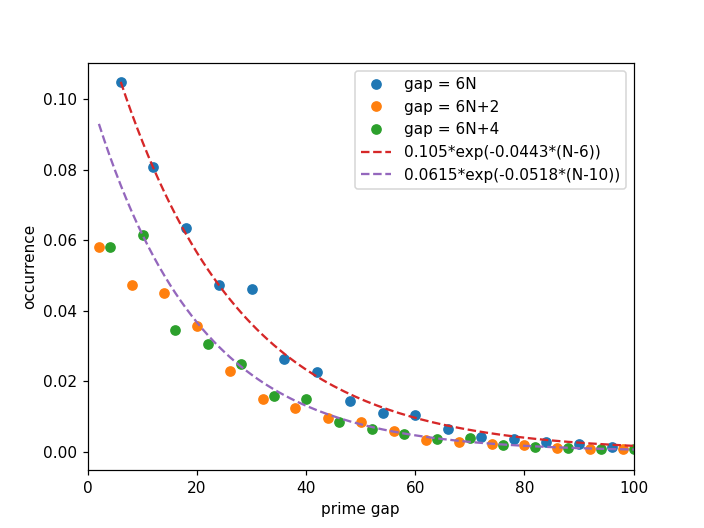

In [55]:
#plotting the results and the model of the distribution of gaps
plt.plot(np.arange(2, 396)[4:150:6], distribution[4:150:6], "o", label = "gap = 6N")
plt.plot(np.arange(2, 396)[:150:6], distribution[:150:6], "o", label = "gap = 6N+2")
plt.plot(np.arange(2, 396)[2:150:6], distribution[2:150:6], "o", label = "gap = 6N+4")

plt.plot(np.arange(2, 396)[4:150], distribution[4:150:6][0]*np.exp(a*(np.arange(2, 396)[4:150] - np.arange(2, 396)[4:150:6][0])) , label = "0.105*exp(-0.0443*(N-6))", linestyle = "--")
plt.plot(np.arange(2, 396)[:150], distribution[2:150:6][1]*np.exp(b*(np.arange(2, 396)[:150] - np.arange(2, 396)[2:150:6][1])) , label = "0.0615*exp(-0.0518*(N-10))", linestyle = "--")
plt.xlim(0, 100)

plt.xlabel("prime gap")
plt.ylabel("occurrence")
plt.legend()

In [12]:
#remodelling with respect to the higher gaps (the first model was designed to fit the low gaps)
a = np.log(distribution[4:300:6][46]/distribution[4:300:6][4])/(np.arange(2, 396)[4:300:6][46] - np.arange(2, 396)[4:300:6][4])

b = np.log(distribution[:300:6][-3]/distribution[:300:6][2])/(np.arange(2, 396)[:300:6][-3] - np.arange(2, 396)[:300:6][2])

distribution[2:300:6][1], b, np.arange(2, 396)[2:300:6][1]

(0.06148437918445314, -0.05256201848463537, 10)

<IPython.core.display.Javascript object>


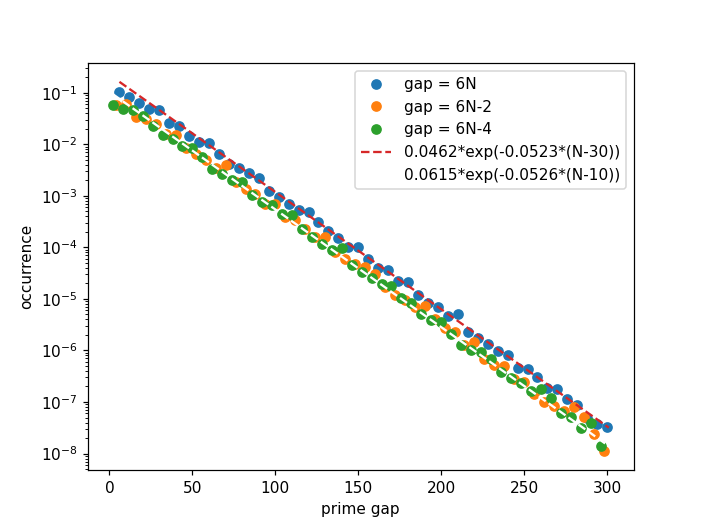

In [6]:
#plotting the new model and the results for further gaps and thus a logarithmic scale on the y-axis
plt.semilogy(np.arange(2, 396)[4:300:6], distribution[4:300:6], "o", label = "gap = 6N")
plt.semilogy(np.arange(2, 396)[2:300:6], distribution[2:300:6], "o", label = "gap = 6N-2")
plt.semilogy(np.arange(2, 396)[:300:6], distribution[:300:6], "o", label = "gap = 6N-4")

plt.semilogy(np.arange(2, 396)[4:300], distribution[4:300:6][4]*np.exp(a*(np.arange(2, 396)[4:300] - np.arange(2, 396)[4:300:6][4])) , label = "0.0462*exp(-0.0523*(N-30))", linestyle = "--")
plt.semilogy(np.arange(2, 396)[:300], distribution[2:300:6][1]*np.exp(b*(np.arange(2, 396)[:300] - np.arange(2, 396)[2:300:6][1])) , label = "0.0615*exp(-0.0526*(N-10))", linestyle = "--", color = "w")

plt.xlabel("prime gap")
plt.ylabel("occurrence")
plt.legend()

Part 6: The largest gap yet between two primes as a function of number of primes before the gap modelled by the inverse function of the gap distribution

<IPython.core.display.Javascript object>


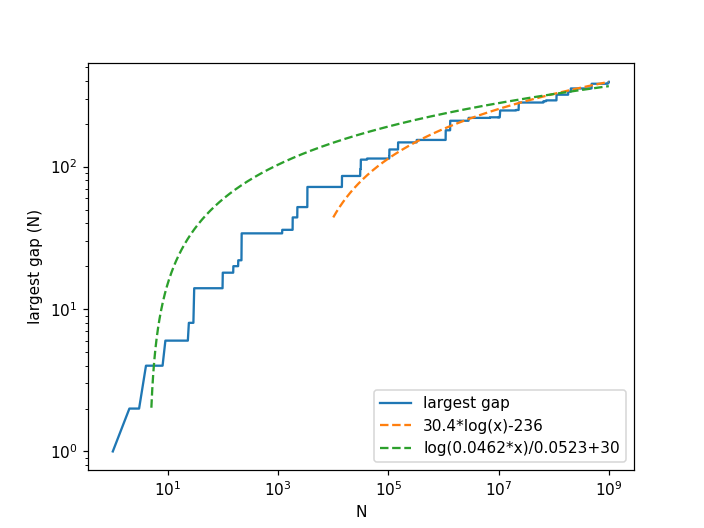

Text(0, 0.5, 'largest gap (N)')

In [16]:
#The exponential nature of the occurence of gaps between prime numbers in part 5 is fascinating. Especially how the gaps divisible by 6 occur more often than the other gaps,
#and how the two cases (divisible by 6 or not) share the same slope. Next the model for the gaps divisible by 6 is used to find another model for the largest
#gap ocurred yet. By setting occurence = 1/n and thus finding the inverse of the function 0.0462*exp(-0.0523*(N-30)) an approximate model for the largest gap is
#plotted again but this time with logarithmic scale on both axes. The inverse function becomes log(0.0462*x)/0.0523+30
N = 1000000000 - 1
x1 = np.logspace(0.7, 9, 10000)
plt.loglog(np.arange(1, N+1)[10000000::100000], gaps[10000000::100000], label = "largest gap", color = "tab:blue")
plt.loglog(np.arange(1, 10000001), gaps[:10000000], color = "tab:blue")
plt.loglog(x, a*np.log(x)+b, color = "tab:orange", label = "30.4*log(x)-236", linestyle = "--")
plt.loglog(x1, np.log(0.0462*x1)/0.0523+30, color = "tab:green", label = "log(0.0462*x)/0.0523+30", linestyle = "--")
# plt.loglog(x1, np.log(0.0615*x1)/0.0526+10, color = "tab:green", label = "log(0.0462*x)/0.0523+30", linestyle = "--")


plt.legend()
plt.xlabel("N")
plt.ylabel("largest gap (N)")


Part 7: Mersenne Primes

In [18]:
#starts at i = 0, not optimal for finding N first primes
def is_prime_general(primes, n): 
    root = np.sqrt(n)
    i = 0
    while primes[i] <= root:
        if n%primes[i] == 0:
            return False
        else:
            i += 1
    return True

In [18]:
#testing all the Mersenne primes lower than the square of the largest prime number found (to avoid index error)
lim = primes[-1]**2
i = 2
while 2**i-1 < lim:
    if is_prime_general(primes, 2**i-1):
        print(i, 2**i-1)
    i+= 1

2 3
3 7
5 31
7 127
13 8191
17 131071
19 524287
31 2147483647
61 2305843009213693951


In [31]:
#2**61-1 was the last Mersenne number smaller than the square of the billionth prime number,
#which is cool as the next Mersenne prime is 2**89-1
lim, (2**62-1)

(3411584144426007873, 4611686018427387903)

In [30]:
#the amount of prime numbers needed for determining whether 2**61-1 is a prime or not is 75 601 571 primes, which is less than a tenth of the primes used here.
np.where(primes > np.sqrt(2**61-1))[0][0]

75601571